## Clustering

In [100]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# also import these "new" libraries 
# Note: you may have to download and add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure
import haversine as hs

# import the necessary libraries for the machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [101]:
# Finished
taxi_df_clustering = pd.read_parquet('data/prepared/taxi_data_prepared.gzip')

### General Data Prep
Before we can start with the clustering, we add an addtional feature to our clustering dataframe.

In [102]:
# Finished dataframe
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078)
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707)
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938)
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688)
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551)
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234)


### Functions to use for Clustering
Next we create a number of functions to help with frequent Clustering Steps:

In [103]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [104]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLossKM(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [105]:
# This function calculates for a defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['ClusterKM'] = result.predict(dataframe)

In [106]:
# This function calculates for a defined amount of clusters GMM on the given dataframe
def calcGMM(numClusters, dataframe):
    gmm = GaussianMixture(n_components=numClusters).fit(dataframe)
    dataframe['ClusterGMM'] = gmm.predict(dataframe)

In [107]:
# This function describes every KMeans or GMM cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters, method):   
    if(method == 'KMeans'):
        for i in range(0, numClusters):
            display(originalDataframe[scaledDataframe['ClusterKM'] == i].describe())
    elif(method == 'GMM'):
        for i in range(0, numClusters):    
            display(originalDataframe[scaledDataframe['ClusterGMM'] == i].describe())
    else:
        print('Error: The wrong method has been chosen. Either use "KMeans" or "GMM"!')

## Clustering Trip/Customer Types

To cluster for Trip/Customer Types we will use the following features in context of the hour of day and weekday:
 - Total number of trips for each hour on each weekday
 - Average Trip Duration in seconds for each hour on each weekday
 - Average Trip Distance in miles for each hour on each weekday

In [108]:
#Additional Data of weekday etc
taxi_df_clustering.loc[:,"weekday"] = taxi_df_clustering["trip_start_timestamp"].dt.weekday
taxi_df_clustering.loc[:,"hour"] = taxi_df_clustering["trip_start_timestamp"].dt.hour

#taxi_df_clustering.loc[:,"day"] = taxi_df_clustering["trip_start_timestamp"].dt.day -> Commented out since we dont need it, but left here if we need it!
#taxi_df_clustering.loc[:,"day"] = taxi_df_clustering["trip_start_timestamp"].dt.day -> Commented out since we dont need it, but left here if we need it!

taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,weekday,hour
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078),4,0
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707),4,0
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),4,0
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938),4,0
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918),4,0
...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688),5,23
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),5,23
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551),5,23
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234),5,23


In [109]:
#Count number of trips per weekday and hour
taxi_df_clustering_wd_hr = taxi_df_clustering.groupby(['weekday','hour'])['hour'].count().reset_index(name='n_trips')

#Aggregate trip duration and distance by weekday and hour
taxi_df_clustering_agg = taxi_df_clustering.groupby(['weekday','hour']).agg({'trip_seconds': 'sum', 'trip_miles': 'sum'}).reset_index()

#Merge both new dataframes
taxi_df_clustering_merged = pd.merge(taxi_df_clustering_agg, taxi_df_clustering_wd_hr)

#Calculate average trip duration and distance
taxi_df_clustering_merged['avg_trip_duration'] = taxi_df_clustering_merged['trip_seconds']/taxi_df_clustering_merged['n_trips']
taxi_df_clustering_merged['avg_trip_distance'] = taxi_df_clustering_merged['trip_miles']/taxi_df_clustering_merged['n_trips']

taxi_df_clustering_merged

,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance
0,0,0,22739048,143167.61,39316,578.366263,3.641459
1,0,1,12367175,69521.81,23471,526.912999,2.962030
2,0,2,5971608,31327.13,13144,454.321972,2.383379
3,0,3,4013208,26069.59,7794,514.909931,3.344828
4,0,4,8130051,101421.21,9144,889.113189,11.091558
...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279
164,6,20,64910329,381760.49,88989,729.419692,4.289974
165,6,21,57335260,364414.95,80923,708.516244,4.503231
166,6,22,48371990,299349.09,73461,658.471706,4.074939


In [110]:
#Create DF to be used for clustering
taxi_df_customer_types_cluster = taxi_df_clustering_merged[['n_trips','avg_trip_duration','avg_trip_distance']]
taxi_df_customer_types_cluster

,n_trips,avg_trip_duration,avg_trip_distance
0,39316,578.366263,3.641459
1,23471,526.912999,2.962030
2,13144,454.321972,2.383379
3,7794,514.909931,3.344828
4,9144,889.113189,11.091558
...,...,...,...
163,106349,751.987851,3.892279
164,88989,729.419692,4.289974
165,80923,708.516244,4.503231
166,73461,658.471706,4.074939


### Soft Clustering with Gaussian Mixture 

In [111]:
#Scaling the Data
taxi_df_customer_types_cluster_scaled = scalingData(taxi_df_customer_types_cluster)
taxi_df_customer_types_cluster_scaled

,n_trips,avg_trip_duration,avg_trip_distance
0,-1.142055,-1.042622,-0.199025
1,-1.363135,-1.389073,-0.526900
2,-1.507225,-1.877852,-0.806141
3,-1.581872,-1.469894,-0.342172
4,-1.563036,1.049738,3.396193
...,...,...,...
163,-0.206764,0.126429,-0.077986
164,-0.448983,-0.025530,0.113931
165,-0.561525,-0.166280,0.216843
166,-0.665640,-0.503246,0.010160


In [112]:
# GMM with 4 Clusters
calcGMM(4, taxi_df_customer_types_cluster_scaled)

display(taxi_df_customer_types_cluster_scaled)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_clustering_merged.loc[:, 'ClusterGMM'] = taxi_df_customer_types_cluster_scaled['ClusterGMM']
taxi_df_clustering_merged

,n_trips,avg_trip_duration,avg_trip_distance,ClusterGMM
0,-1.142055,-1.042622,-0.199025,2
1,-1.363135,-1.389073,-0.526900,2
2,-1.507225,-1.877852,-0.806141,2
3,-1.581872,-1.469894,-0.342172,2
4,-1.563036,1.049738,3.396193,1
...,...,...,...,...
163,-0.206764,0.126429,-0.077986,0
164,-0.448983,-0.025530,0.113931,0
165,-0.561525,-0.166280,0.216843,0
166,-0.665640,-0.503246,0.010160,2


,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance,ClusterGMM
0,0,0,22739048,143167.61,39316,578.366263,3.641459,2
1,0,1,12367175,69521.81,23471,526.912999,2.962030,2
2,0,2,5971608,31327.13,13144,454.321972,2.383379,2
3,0,3,4013208,26069.59,7794,514.909931,3.344828,2
4,0,4,8130051,101421.21,9144,889.113189,11.091558,1
...,...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279,0
164,6,20,64910329,381760.49,88989,729.419692,4.289974,0
165,6,21,57335260,364414.95,80923,708.516244,4.503231,0
166,6,22,48371990,299349.09,73461,658.471706,4.074939,2


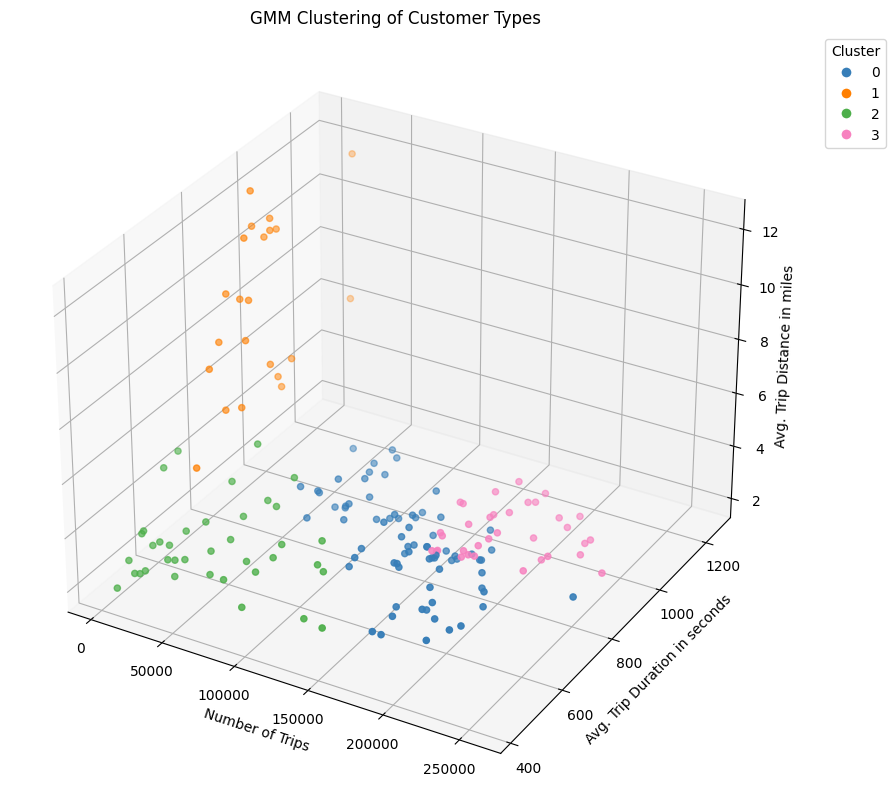

In [113]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_clustering_merged['n_trips'], ys=taxi_df_clustering_merged['avg_trip_duration'], zs=taxi_df_clustering_merged['avg_trip_distance'], c=taxi_df_clustering_merged['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('GMM Clustering of Customer Types')
plt.xlabel('Number of Trips')
plt.ylabel('Avg. Trip Duration in seconds')
ax.set_zlabel('Avg. Trip Distance in miles')
ax.zaxis.labelpad = 0
plt.show()

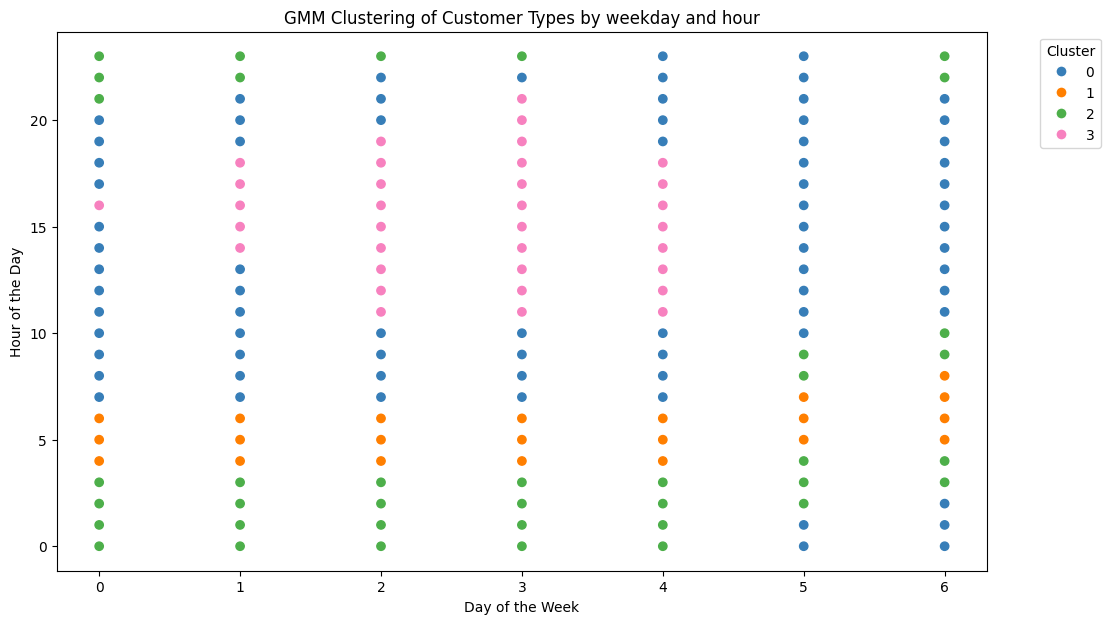

In [114]:
#Plot the cluster result by hour and weekday
plt.figure(figsize=(12,7))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

plt.scatter(x=taxi_df_clustering_merged['weekday'], y=taxi_df_clustering_merged['hour'], c=taxi_df_clustering_merged['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('GMM Clustering of Customer Types by weekday and hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [115]:
#Describing the data of each GMM cluster
describeData(taxi_df_customer_types_cluster, taxi_df_customer_types_cluster_scaled, 4, 'GMM')

,n_trips,avg_trip_duration,avg_trip_distance
count,74.000000,74.000000,74.000000
mean,152211.418919,727.117574,3.358653
std,37518.917875,89.936188,0.640159
min,80923.000000,515.675483,2.158819
25%,124950.250000,680.191692,2.918993
50%,156849.500000,731.416904,3.383184
75%,179592.000000,777.949669,3.775414
max,256148.000000,915.555761,4.588779


,n_trips,avg_trip_duration,avg_trip_distance
count,22.000000,22.000000,22.000000
mean,19149.409091,889.561437,8.746662
std,11470.689615,135.965718,2.169736
min,3510.000000,605.001018,5.240986
25%,10598.250000,822.105703,6.889678
50%,15495.500000,883.164394,8.616939
75%,31187.250000,952.299729,10.830526
max,38553.000000,1249.065201,12.310991


,n_trips,avg_trip_duration,avg_trip_distance
count,38.000000,38.000000,38.000000
mean,51192.684211,551.882121,3.198040
std,37810.593375,73.008921,0.873004
min,2371.000000,422.875416,2.011312
25%,17364.500000,498.495408,2.587876
50%,46354.000000,534.004231,3.033943
75%,76119.750000,595.453482,3.594079
max,135685.000000,709.564411,5.600295


,n_trips,avg_trip_duration,avg_trip_distance
count,34.000000,34.000000,34.000000
mean,197822.205882,847.968217,3.487063
std,23620.744253,94.046635,0.405305
min,162621.000000,699.668231,2.740295
25%,179715.000000,760.511722,3.070753
50%,192841.500000,852.079752,3.618638
75%,217965.750000,935.535940,3.742608
max,258060.000000,1008.647432,4.148646


### Comparisent with Hard Clustering using KMeans

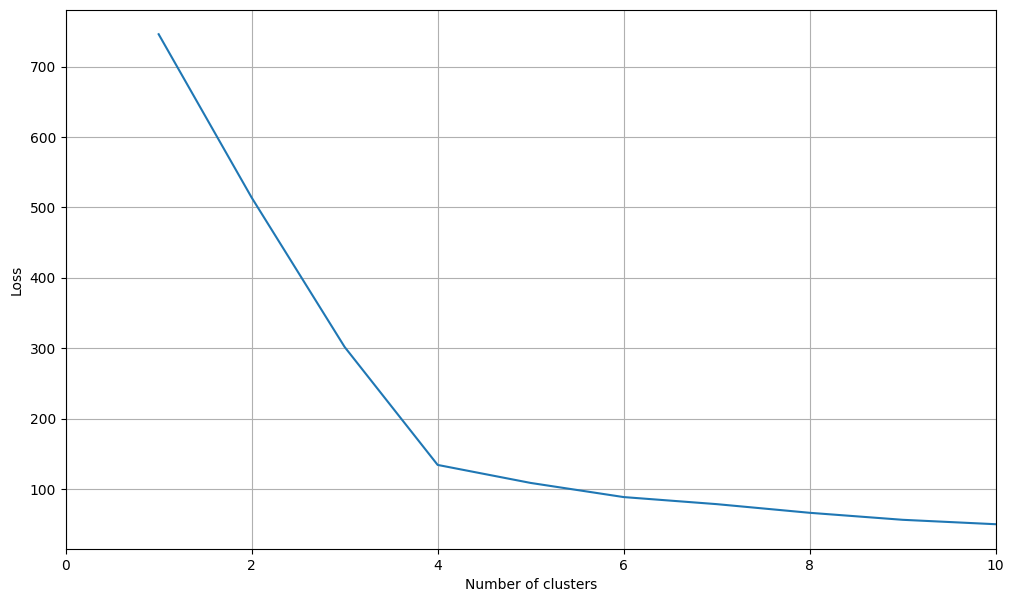

In [116]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLossKM(10, taxi_df_customer_types_cluster_scaled)

In [117]:
# Define the cluster amount here
cluster = 4

# Calculating KMeans
calcKMeans(cluster, taxi_df_customer_types_cluster_scaled)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_clustering_merged.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_scaled['ClusterKM']
taxi_df_clustering_merged

,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance,ClusterGMM,ClusterKM
0,0,0,22739048,143167.61,39316,578.366263,3.641459,2,2
1,0,1,12367175,69521.81,23471,526.912999,2.962030,2,2
2,0,2,5971608,31327.13,13144,454.321972,2.383379,2,2
3,0,3,4013208,26069.59,7794,514.909931,3.344828,2,2
4,0,4,8130051,101421.21,9144,889.113189,11.091558,1,3
...,...,...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279,0,0
164,6,20,64910329,381760.49,88989,729.419692,4.289974,0,0
165,6,21,57335260,364414.95,80923,708.516244,4.503231,0,0
166,6,22,48371990,299349.09,73461,658.471706,4.074939,2,2


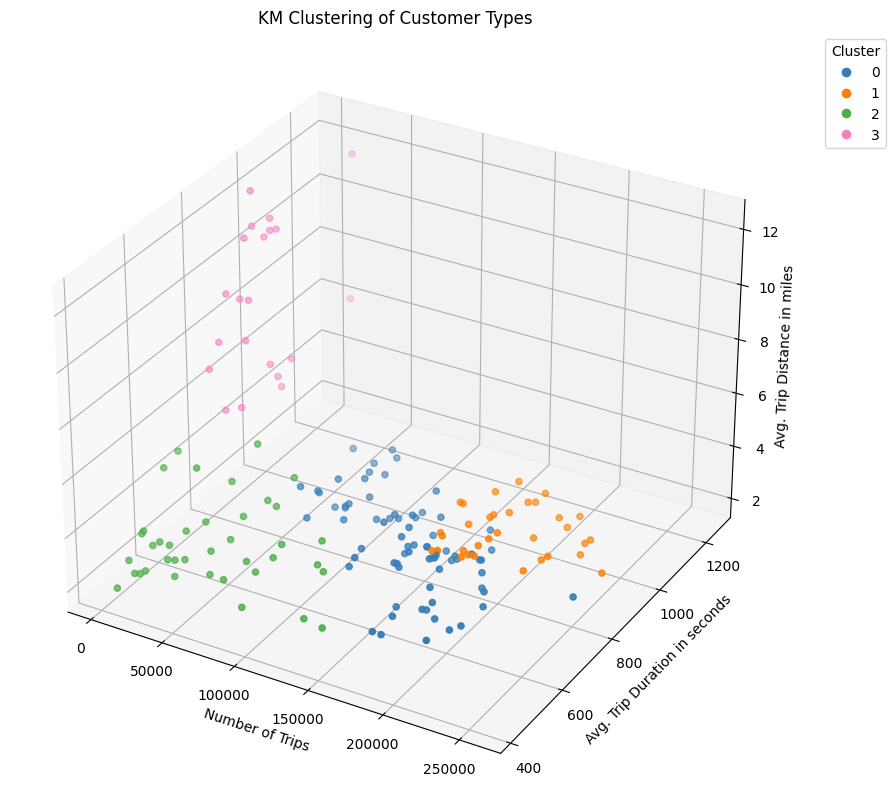

In [118]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_clustering_merged['n_trips'], ys=taxi_df_clustering_merged['avg_trip_duration'], zs=taxi_df_clustering_merged['avg_trip_distance'], c=taxi_df_clustering_merged['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KM Clustering of Customer Types')
plt.xlabel('Number of Trips')
plt.ylabel('Avg. Trip Duration in seconds')
ax.set_zlabel('Avg. Trip Distance in miles')
ax.zaxis.labelpad = 0
plt.show()

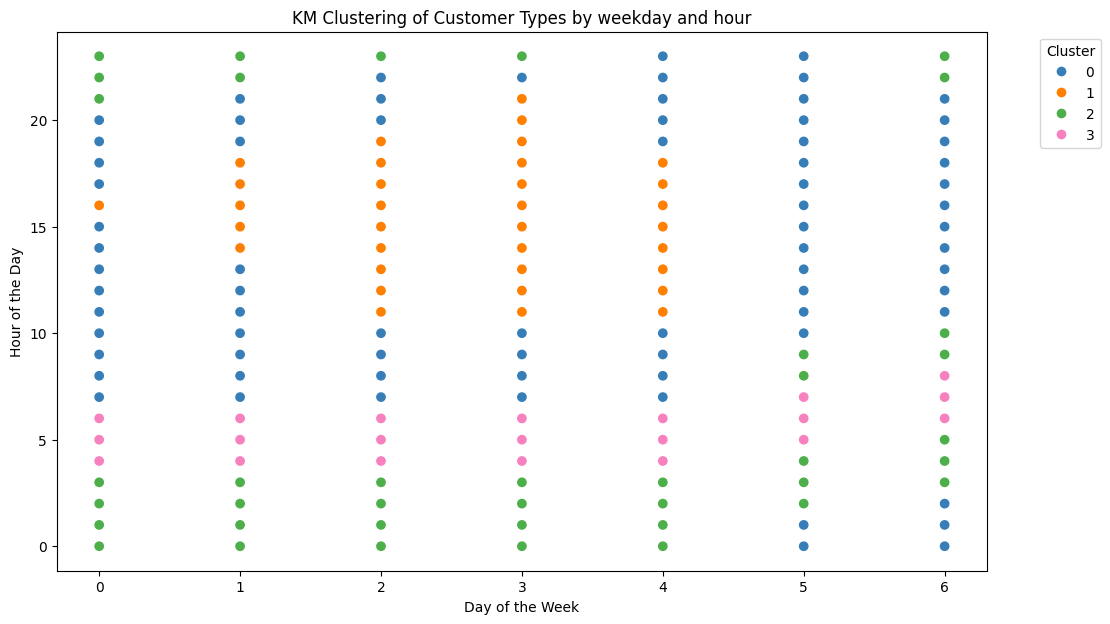

In [119]:
#Plot the cluster result by hour and weekday
plt.figure(figsize=(12,7))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

plt.scatter(x=taxi_df_clustering_merged['weekday'], y=taxi_df_clustering_merged['hour'], c=taxi_df_clustering_merged['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KM Clustering of Customer Types by weekday and hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [120]:
#Describing the data of each KMeans cluster
describeData(taxi_df_customer_types_cluster, taxi_df_customer_types_cluster_scaled, 4, 'KMeans')

,n_trips,avg_trip_duration,avg_trip_distance
count,74.000000,74.000000,74.000000
mean,152211.418919,727.117574,3.358653
std,37518.917875,89.936188,0.640159
min,80923.000000,515.675483,2.158819
25%,124950.250000,680.191692,2.918993
50%,156849.500000,731.416904,3.383184
75%,179592.000000,777.949669,3.775414
max,256148.000000,915.555761,4.588779


,n_trips,avg_trip_duration,avg_trip_distance
count,34.000000,34.000000,34.000000
mean,197822.205882,847.968217,3.487063
std,23620.744253,94.046635,0.405305
min,162621.000000,699.668231,2.740295
25%,179715.000000,760.511722,3.070753
50%,192841.500000,852.079752,3.618638
75%,217965.750000,935.535940,3.742608
max,258060.000000,1008.647432,4.148646


,n_trips,avg_trip_duration,avg_trip_distance
count,39.000000,39.000000,39.000000
mean,50610.282051,553.244144,3.250423
std,37486.628806,72.542268,0.921464
min,2371.000000,422.875416,2.011312
25%,18093.000000,499.211517,2.614067
50%,42772.000000,541.095462,3.057354
75%,75233.500000,600.964813,3.686828
max,135685.000000,709.564411,5.600295


,n_trips,avg_trip_duration,avg_trip_distance
count,21.000000,21.000000,21.000000
mean,18705.142857,903.111933,8.913599
std,11558.384482,123.164451,2.073498
min,3510.000000,738.074166,6.009362
25%,10503.000000,835.723323,7.120486
50%,13381.000000,886.405923,9.132587
75%,32090.000000,955.007331,10.880581
max,38553.000000,1249.065201,12.310991
